In [1]:
%autoreload 2
%matplotlib ipympl
import os
import glob
import re 
import numpy as np
import matplotlib.pyplot as plt
from qwfs.qwfs_result import QWFSResult
from qwfs.qwfs_simulation import QWFSSimulation

DATA_DIR = os.path.join(os.path.abspath(os.path.curdir), 'data')

# 1) Assert analytic results agree with autograd-BFGS
## 1.1 the enhancement is similar

---- SLM1-only-T ----
-- unitary --
autograd-lbfgs            0.785+-0.01
analytic                  0.785+-0.01
-- gaus_iid --
autograd-lbfgs            0.790+-0.05
analytic                  0.790+-0.05

---- SLM2-simple ----
-- unitary --
autograd-lbfgs            0.616+-0.03
analytic                  0.616+-0.03
-- gaus_iid --
autograd-lbfgs            0.628+-0.07
analytic                  0.628+-0.07

---- SLM2-simple-OPC ----
-- unitary --
autograd-lbfgs            1.000+-0.00
analytic                  1.000+-0.00
-- gaus_iid --
autograd-lbfgs            1.006+-0.13
analytic                  1.006+-0.13



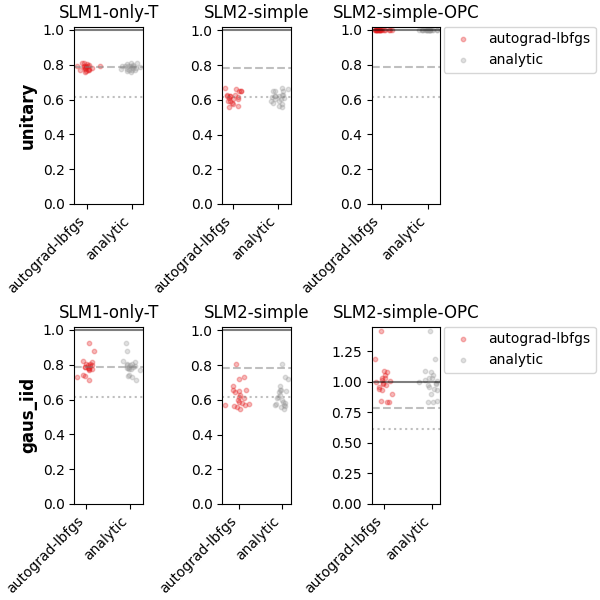

In [132]:
path = glob.glob(rf'{DATA_DIR}\*adam_vrs_analytic*')[-1]
res = QWFSResult(path)
res.print()
fig = res.show_scatterplots()
fig.savefig(rf'G:\My Drive\Projects\ScalingQWFS\Paper\Figures\optimizer_sanity')
plt.show()

## 1.2 the actual found phases are the same
ADAM finds the optimal phases for N=256

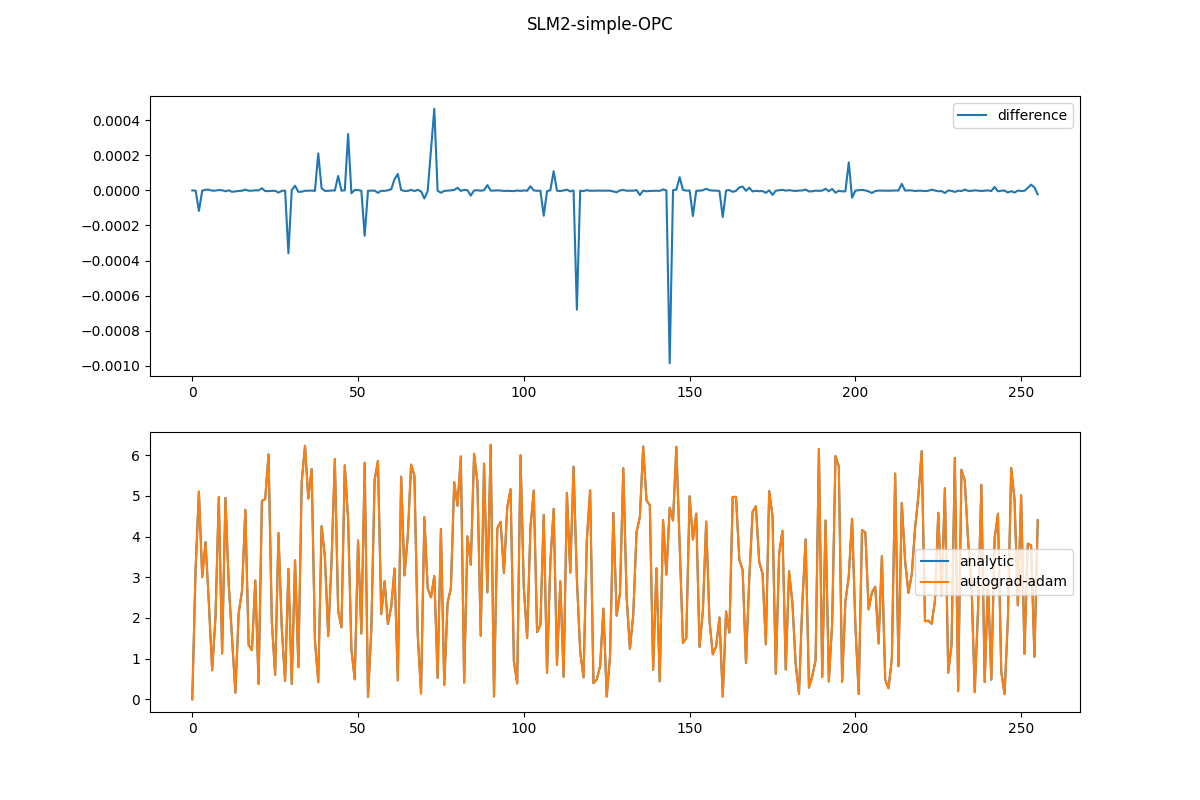

In [131]:
path = glob.glob(rf'{DATA_DIR}\*_adam_vrs_analytic*')[-1]
res = QWFSResult(path)

T_method = 'unitary'
config = 'SLM2-simple-OPC'
try_no = np.random.randint(1, res.N_tries)
try_no=0
phases_analytic = res.get_phases(config=config, T_method=T_method, alg='analytic', try_no=try_no)
phases_adam = res.get_phases(config=config, T_method=T_method, alg='autograd-lbfgs', try_no=try_no)

phases_analytic -= phases_analytic[0]
phases_adam -= phases_adam[0]

phases_analytic = phases_analytic % (2*np.pi)
phases_adam = phases_adam % (2*np.pi)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle(config)
axes[1].plot(phases_analytic, label='analytic')
axes[1].plot(phases_adam, label='autograd-adam')
axes[1].legend()

axes[0].plot(phases_analytic - phases_adam, label='difference')
axes[0].legend()

fig.savefig(rf'G:\My Drive\Projects\ScalingQWFS\Paper\Figures\optimizer_find_same_phases.png')

## 1.3 adding the FFTs does not change things 
SLM3 configuration will use FFTs, etc. so we make sure that also SLM1 and SLM2 in these slightly more complex configurations show the same results. 

In [40]:
path = glob.glob(rf'{DATA_DIR}\*adam_SLM1_SLM2_with_FFTs*')[-1]
res = QWFSResult(path)
res.print()

---- SLM1 ----
-- unitary --
autograd-adam             0.784+-0.02
-- gaus_iid --
autograd-adam             0.793+-0.08

---- SLM2 ----
-- unitary --
autograd-adam             0.623+-0.03
-- gaus_iid --
autograd-adam             0.621+-0.07

---- SLM2-same-mode ----
-- unitary --
autograd-adam             1.000+-0.00
-- gaus_iid --
autograd-adam             1.005+-0.12



# 2) comparing optimizers
See logs in the generate_results notebook. It could be seen that the runtimes of different optimizers scale differently. Most notably:
 
* Simulated annealing, which is supposed to be better at finding a global optimum takes much longer, and scales badly with the size of the system, and does not show consistent better enhancement.
* Using the autograd engine, which uses analytical gradient data, speeds things up significantly, and also achieves better performance.
* The LBFGS pytorch optimizer performs slightly better than the ADAM pytorch optimizer, and takes only ~4X longer, so we would use it. 

# 3) numerical SLM3 results
From these results we quote the approximate SLM3 results 

In [50]:
path = glob.glob(rf'{DATA_DIR}\*SLM3*tries*')[-1]
res = QWFSResult(path)
res.print()
# res.show_scatterplots()

---- SLM3 ----
-- unitary --
autograd-adam             0.877+-0.01
autograd-lbfgs            0.881+-0.01
-- gaus_iid --
autograd-adam             1.864+-0.08
autograd-lbfgs            1.870+-0.08

---- SLM3-same-mode ----
-- unitary --
autograd-adam             1.000+-0.00
autograd-lbfgs            1.000+-0.00
-- gaus_iid --
autograd-adam             4.517+-0.18
autograd-lbfgs            4.540+-0.19



# 4) SLM3 full data example 

I_in.sum()=1.0
I_middle_optimized.sum()=1.8889144840094194
I_out_optimized.sum()=2.9626374496707255


C:\Users\owner\AppData\Local\Temp\ipykernel_19292\3294844293.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


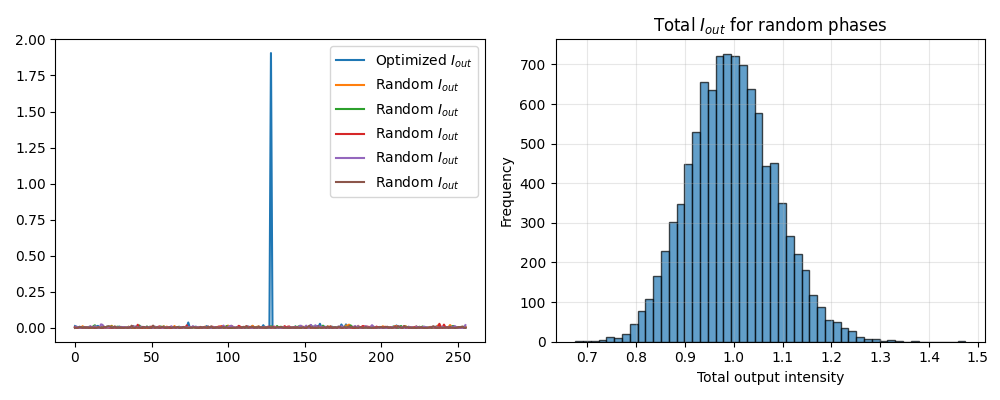

In [133]:
path = glob.glob(rf'{DATA_DIR}\*SLM3_full_data*')[-1]
res = QWFSResult(path)

# Set simulation 
try_no = np.random.randint(res.N_tries)
# try_no = 5
alg = 'autograd-lbfgs'
# config = 'SLM3-same-mode'
config = 'SLM3'
T_method = 'gaus_iid'
# T_method = 'unitary'
alg_ind = np.where(res.algos == alg)[0]
conf_ind = np.where(res.configs == config)[0]
T_method_ind = np.where(res.T_methods == T_method)[0] 
T_ind = res.N_T_methods * try_no + T_method_ind 
T = res.Ts[T_ind].squeeze()
slm_phases = res.best_phases[T_method_ind, conf_ind, try_no, alg_ind].squeeze()
N = len(slm_phases)

sim = QWFSSimulation(N=N)
sim.T = T 
sim.slm_phases = np.exp(1j*slm_phases)
sim.config = config

# get relevant information 
v_out = sim.propagate()
I_out_optimized = np.abs(v_out)**2
I_in = np.abs(sim.v_in)**2
v_middle = sim.T.transpose() @ (sim.slm_phases * sim.v_in)
I_middle_optimized = np.abs(v_middle)**2

print(f'{I_in.sum()=}')
print(f'{I_middle_optimized.sum()=}')
print(f'{I_out_optimized.sum()=}')


tot_Is = []
for i in range(10000):
    random_phases = np.random.uniform(0, 2*np.pi, sim.N)
    sim.slm_phases = np.exp(1j*random_phases)
    v_out = sim.propagate()
    I_out = np.abs(v_out)**2
    tot_Is.append(I_out.sum())
    
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(I_out_optimized, label='Optimized $I_{out}$')
for i in range(5):
    random_phases = np.random.uniform(0, 2*np.pi, sim.N)
    sim.slm_phases = np.exp(1j*random_phases)
    v_out = sim.propagate()
    I_out = np.abs(v_out)**2
    ax1.plot(I_out, label='Random $I_{out}$')

ax1.legend()

# Create the histogram
ax2.hist(tot_Is, bins=50, edgecolor='black', alpha=0.7)
ax2.set_title('Total $I_{out}$ for random phases')
ax2.set_xlabel('Total output intensity')
ax2.set_ylabel('Frequency')

show_mean = False
if show_mean:
    ax2.axvline(np.mean(tot_Is), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(tot_Is):.2f}')
    ax2.axvline(np.median(tot_Is), color='green', linestyle='dashed', linewidth=2, label=f'Median: {np.median(tot_Is):.2f}')

ax2.grid(True, alpha=0.3)

# Adjust layout and display
plt.tight_layout()
fig.savefig(rf'G:\My Drive\Projects\ScalingQWFS\Paper\Figures\full_data_example.png')

# 5) 0, $\pi$ phases in SLM3 OPC

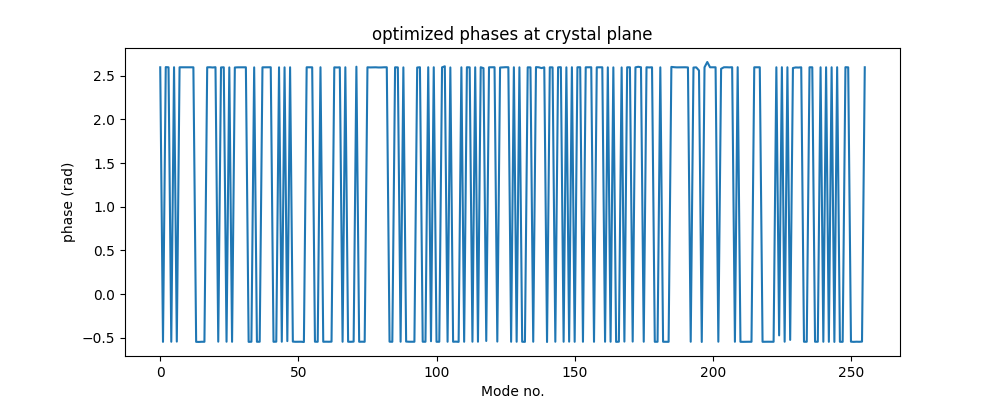

In [134]:
path = glob.glob(rf'{DATA_DIR}\*SLM3_full_data*')[-1]
res = QWFSResult(path)

alg = 'autograd-lbfgs'
config = 'SLM3-same-mode'
# T_method = 'gaus_iid'
T_method = 'unitary'
# try_no = np.random.randint(res.N_tries)
try_no = 0

alg_ind = np.where(res.algos == alg)[0]
conf_ind = np.where(res.configs == config)[0]
T_method_ind = np.where(res.T_methods == T_method)[0]

T_ind = res.N_T_methods * try_no + T_method_ind
T = res.Ts[T_ind].squeeze()
slm_phases = res.best_phases[T_method_ind, conf_ind, try_no, alg_ind].squeeze()
N = len(slm_phases)

sim = QWFSSimulation(N=N)
sim.T = T
sim.slm_phases = np.exp(1j * slm_phases)
sim.config = config

E_middle = sim.T.transpose() @ (sim.slm_phases * sim.v_in)
phases = np.angle(E_middle)
# I_middle = np.abs(E_middle) ** 2
# I_out = np.abs(sim.propagate()) ** 2


fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(phases)
ax.set_title(f'optimized phases at crystal plane')
ax.set_xlabel('Mode no.')
ax.set_ylabel('phase (rad)')
fig.savefig(rf'G:\My Drive\Projects\ScalingQWFS\Paper\Figures\zero_pi_phases.png')

# 6) Figure 3 - results summary

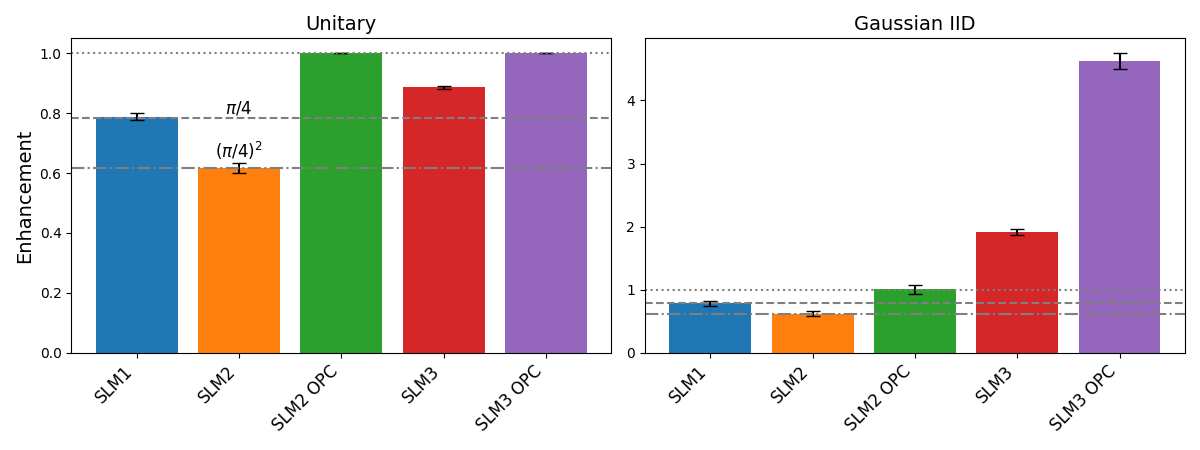

In [17]:
import matplotlib.pyplot as plt
import numpy as np

path = glob.glob(rf'{DATA_DIR}\*all_configs*')[-1]
res = QWFSResult(path)
alg = 'autograd-lbfgs'
alg_ind = np.where(res.algos == 'autograd-lbfgs')[0]

configs = ["SLM1", "SLM2", "SLM2-same-mode", "SLM3", "SLM3-same-mode"]
labels = ["SLM1", "SLM2", "SLM2 OPC", "SLM3", "SLM3 OPC"]

unitary_data = []
unitary_data_std = []
gaussian_data = []
gaussian_data_std = []

for config in configs:
    T_method_ind = np.where(res.T_methods == 'unitary')[0]
    effs_unitary = res.results[T_method_ind, np.where(res.configs == config)[0], :, alg_ind].squeeze()
    T_method_ind = np.where(res.T_methods == 'gaus_iid')[0]
    effs_gaus = res.results[T_method_ind, np.where(res.configs == config)[0], :, alg_ind].squeeze()
    
    unitary_data.append(effs_unitary.mean())
    unitary_data_std.append(effs_unitary.std()) # / np.sqrt(res.N_tries))
    
    gaussian_data.append(effs_gaus.mean())
    gaussian_data_std.append(effs_gaus.std()) # / np.sqrt(res.N_tries))

x = np.arange(len(labels))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5), sharey=False)

rects1 = ax1.bar(x, unitary_data, color=colors, yerr=unitary_data_std, 
                 error_kw={'ecolor': 'black', 'capsize': 5, 'elinewidth': 1.5})
ax1.axhline(y=np.pi / 4, color='#7f7f7f', linestyle='--', label='$\pi/4$')
ax1.axhline(y=(np.pi / 4) ** 2, color='#7f7f7f', linestyle='-.', label='$(\pi/4)^2$')
ax1.axhline(y=1.0, color='#7f7f7f', linestyle=':', label='$1$')
ax1.set_title('Unitary', fontsize=14)
ax1.set_ylabel('Enhancement', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=12)
ax1.text(x[1], np.pi / 4, '$\pi/4$', color='black', fontsize=12, va='bottom', ha='center')
ax1.text(x[1], (np.pi / 4) ** 2 + 0.02, '$(\pi/4)^2$', color='black', fontsize=12, va='bottom', ha='center')
# ax1.legend()

rects2 = ax2.bar(x, gaussian_data, color=colors, yerr=gaussian_data_std, 
                 error_kw={'ecolor': 'black', 'capsize': 5, 'elinewidth': 1.5})
ax2.axhline(y=np.pi / 4, color='#7f7f7f', linestyle='--', label='$\pi/4$')
ax2.axhline(y=(np.pi / 4) ** 2, color='#7f7f7f', linestyle='-.', label='$(\pi/4)^2$')
ax2.axhline(y=1.0, color='#7f7f7f', linestyle=':', label='$1$')
ax2.set_title('Gaussian IID', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=12)
# ax2.legend(fontsize=14)

fig.tight_layout()
plt.show()
fig.savefig(r"G:\My Drive\Projects\ScalingQWFS\Paper\Figures\results_summary.png")

# 7) N-dependence of SLM3

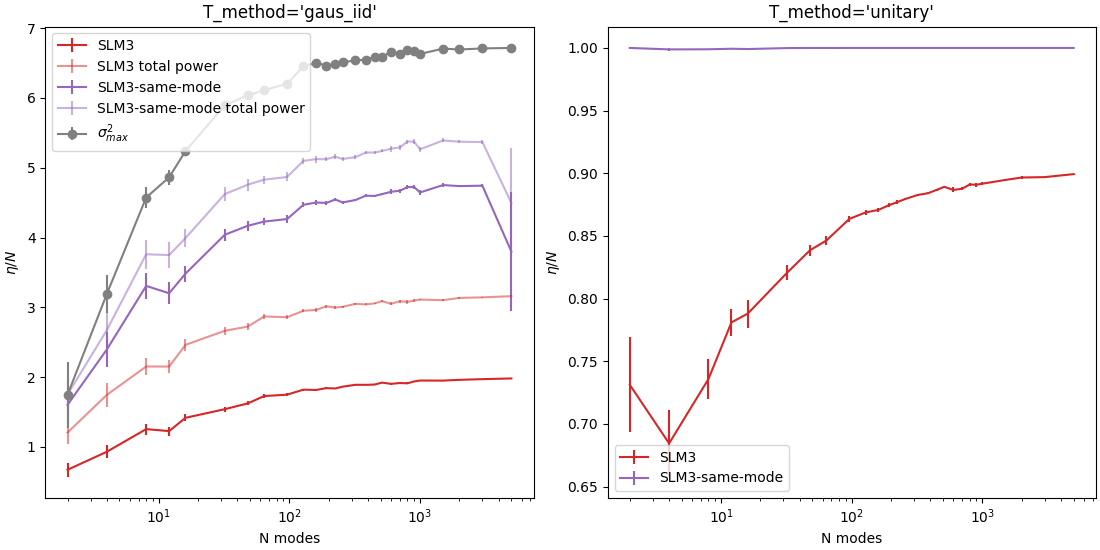

In [73]:
paths = glob.glob(rf'{DATA_DIR}\N_dep\*_Nmodes_*')
ress = [QWFSResult(path) for path in paths]
Ns = np.array([re.findall('.*Nmodes_(\d+).npz', path)[0] for path in paths]).astype(float)
Ns, ress = list(zip(*sorted(zip(Ns, ress), key=lambda pair: pair[0])))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(11, 5.5))

for ax, T_method in zip(axes, ress[0].T_methods[::-1]):
    effs_SLM3 = np.zeros_like(Ns)
    stds_SLM3 = np.zeros_like(Ns)
    tot_I_outs_SLM3 = np.zeros_like(Ns)
    tot_I_outs_std_SLM3 = np.zeros_like(Ns)
    effs_SLM3_OPC = np.zeros_like(Ns)
    stds_SLM3_OPC = np.zeros_like(Ns)
    tot_I_outs_SLM3_OPC = np.zeros_like(Ns)
    tot_I_outs_std_SLM3_OPC = np.zeros_like(Ns)
    max_SVDs = np.zeros_like(Ns)
    max_SVDs_std = np.zeros_like(Ns)

    alg_ind = np.where(ress[0].algos == 'autograd-lbfgs')[0]
    T_method_ind = np.where(ress[0].T_methods == T_method)[0]

    for i, N in enumerate(Ns):
        res = ress[i]
        effs = res.results[T_method_ind, np.where(res.configs == 'SLM3')[0], :, alg_ind].squeeze()
        effs_SLM3[i] = effs.mean(); stds_SLM3[i] = effs.std() / np.sqrt(res.results.shape[2])
        
        tot_I_outs = res.tot_power_results[T_method_ind, np.where(res.configs == 'SLM3')[0], :, alg_ind].squeeze()
        tot_I_outs_SLM3[i] = tot_I_outs.mean(); tot_I_outs_std_SLM3[i] = tot_I_outs.std() / np.sqrt(res.results.shape[2])
        
        effs = res.results[T_method_ind, np.where(res.configs == 'SLM3-same-mode')[0], :, alg_ind].squeeze()
        tot_I_outs = res.tot_power_results[T_method_ind, np.where(res.configs == 'SLM3-same-mode')[0], :, alg_ind].squeeze()
        effs_SLM3_OPC[i] = effs.mean(); stds_SLM3_OPC[i] = effs.std() / np.sqrt(res.results.shape[2])
        tot_I_outs_SLM3_OPC[i] = tot_I_outs.mean(); tot_I_outs_std_SLM3_OPC[i] = tot_I_outs.std() / np.sqrt(res.results.shape[2])

        if T_method == 'gaus_iid':
            T_method_no = np.where(ress[0].T_methods == 'gaus_iid')[0][0]
            these_svds = res.max_SVDs[T_method_no::2]
            max_SVDs[i] = these_svds.mean()**2 
            max_SVDs_std[i] = these_svds.std()**2 
        
    times_N = False
    if times_N:
        effs_SLM3 *= Ns
        effs_SLM3_OPC *= Ns
        max_SVDs *= Ns
        tot_I_outs_SLM3 *= Ns
        tot_I_outs_SLM3_OPC *= Ns
    
    if not T_method == 'gaus_iid':
        lines = ax.errorbar(Ns, effs_SLM3, stds_SLM3, label='SLM3', color=colors[3])
        lines_OPC = ax.errorbar(Ns, effs_SLM3_OPC, stds_SLM3_OPC, label='SLM3-same-mode', color=colors[4])
        ax.legend()
    else:       
        lines = ax.errorbar(Ns, effs_SLM3, stds_SLM3, label='SLM3', color=colors[3])
        ax.errorbar(Ns, tot_I_outs_SLM3, tot_I_outs_std_SLM3, label='SLM3 total power', color=lines[0].get_c(), alpha=0.5)
        lines_OPC = ax.errorbar(Ns, effs_SLM3_OPC, stds_SLM3_OPC, label='SLM3-same-mode', color=colors[4])
        ax.errorbar(Ns, tot_I_outs_SLM3_OPC, tot_I_outs_std_SLM3_OPC, label='SLM3-same-mode total power', color=lines_OPC[0].get_c(), alpha=0.5)
        ax.errorbar(Ns, max_SVDs, max_SVDs_std, label=r'$\sigma_{max}^2$', marker='o', color='gray')
        # ax.legend(loc='upper center', bbox_to_anchor=(0.1, 0.9), ncol=2)
        ax.legend()

    ax.set_xlabel('N modes')
    ax.set_ylabel('$\eta/N$')
    ax.set_title(f'{T_method=}') 
    ax.set_xscale('log')
    
fig.savefig(r"G:\My Drive\Projects\ScalingQWFS\Paper\Figures\N_dependence.png")

# 8) incopmlete control 

In [84]:
from scipy.optimize import curve_fit

def incomplete_control(small_control=False):
    paths = glob.glob(rf'{DATA_DIR}\incomplete_control\2025_01_12*_Npixels_*')
    ress = [QWFSResult(path) for path in paths]
    N_pixs = np.array([re.findall('.*Npixels_(\d+).npz', path)[0] for path in paths]).astype(float)
    N_pixs, ress = list(zip(*sorted(zip(N_pixs, ress), key=lambda pair: pair[0])))
    N_pixs, ress = np.array(N_pixs), np.array(ress)
    
    DOCs = N_pixs / ress[0].N_modes
    
    fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 5))
    
    for ax, T_method in zip(axes, ress[0].T_methods):
        N_tries = ress[0].N_tries
        effs_SLM1 = np.zeros_like(N_pixs)
        stds_SLM1 = np.zeros_like(N_pixs)
        effs_SLM2 = np.zeros_like(N_pixs)
        stds_SLM2 = np.zeros_like(N_pixs)
        effs_SLM2_OPC = np.zeros_like(N_pixs)
        stds_SLM2_OPC = np.zeros_like(N_pixs)
        effs_SLM3 = np.zeros_like(N_pixs)
        stds_SLM3 = np.zeros_like(N_pixs)
        effs_SLM3_OPC = np.zeros_like(N_pixs)
        stds_SLM3_OPC = np.zeros_like(N_pixs)
        alg_ind = np.where(ress[0].algos == 'autograd-lbfgs')[0]
        T_method_ind = np.where(ress[0].T_methods == T_method)[0]
    
        for i, DOC in enumerate(DOCs):
            res = ress[i]       
            effs = res.results[T_method_ind, np.where(res.configs == 'SLM1')[0], :, alg_ind].squeeze()
            effs_SLM1[i] = effs.mean(); stds_SLM1[i] = effs.std() / np.sqrt(N_tries)
            
            effs = res.results[T_method_ind, np.where(res.configs == 'SLM2')[0], :, alg_ind].squeeze()
            effs_SLM2[i] = effs.mean(); stds_SLM2[i] = effs.std() / np.sqrt(N_tries)
    
            effs = res.results[T_method_ind, np.where(res.configs == 'SLM2-same-mode')[0], :, alg_ind].squeeze()
            effs_SLM2_OPC[i] = effs.mean(); stds_SLM2_OPC[i] = effs.std() / np.sqrt(N_tries)
            
            effs = res.results[T_method_ind, np.where(res.configs == 'SLM3')[0], :, alg_ind].squeeze()
            effs_SLM3[i] = effs.mean(); stds_SLM3[i] = effs.std() / np.sqrt(N_tries)
    
            effs = res.results[T_method_ind, np.where(res.configs == 'SLM3-same-mode')[0], :, alg_ind].squeeze()
            effs_SLM3_OPC[i] = effs.mean(); stds_SLM3_OPC[i] = effs.std() / np.sqrt(N_tries)
            
        lines_SLM1 = ax.errorbar(DOCs, effs_SLM1, stds_SLM1, label='SLM1')
        lines_SLM2 = ax.errorbar(DOCs, effs_SLM2, stds_SLM2, label='SLM2')
        lines_SLM2_OPC = ax.errorbar(DOCs, effs_SLM2_OPC, stds_SLM2_OPC, label='SLM2-OPC')
        
        lines_SLM3 = ax.errorbar(DOCs, effs_SLM3, stds_SLM3, label='SLM3')
        lines_SLM3_OPC = ax.errorbar(DOCs, effs_SLM3_OPC, stds_SLM3_OPC, label='SLM3-OPC')
            
        ax.plot([0, 1], [0, np.pi/4], color=lines_SLM1[0].get_c(), linestyle='--', alpha=0.5)
        if not small_control:
            ax.plot([0, 1], [0, (np.pi/4)**2], color=lines_SLM2[0].get_c(), linestyle='--', alpha=0.5)
            ax.plot([0, 1], [0, 1], color=lines_SLM2_OPC[0].get_c(), linestyle='--', alpha=0.5)
            ax.plot([0, 1], [0, effs_SLM3.max()], color=lines_SLM3[0].get_c(), linestyle='--', alpha=0.5)
            if T_method == 'gaus_iid':
                ax.plot([0, 1], [0, effs_SLM3_OPC.max()], color=lines_SLM3_OPC[0].get_c(), linestyle='--', alpha=0.5)
            ax.set_xlim((-0.01, None))
            ax.set_ylim((-0.01, None))

        else:
            ax.plot([0, 1], [0, np.pi/2], color=lines_SLM2_OPC[0].get_c(), linestyle='--', alpha=0.5)            
            n_points = 9
            p, cov = curve_fit(lambda x, a, b: a*x+b, DOCs[:n_points], effs_SLM3[:n_points], bounds=(0, 5), loss='huber')
            a3, b3 = p[0], p[1]
            p, cov_opc = curve_fit(lambda x, a, b: a*x+b, DOCs[:n_points], effs_SLM3_OPC[:n_points], bounds=(0, 5), loss='huber')
            a3opc, b3opc = p[0], p[1]
            ax.plot([0, 1], [b3, b3+a3], color=lines_SLM3[0].get_c(), linestyle='--', alpha=0.5)
            ax.plot([0, 1], [b3opc, b3opc+a3opc], color=lines_SLM3_OPC[0].get_c(), linestyle='--', alpha=0.5)
            print(f'{T_method=}: {a3=:.3f}+-{cov[0, 0]:.3f}; {b3=:.3f} +- {cov[1, 1]:.3f}')
            print(f'{T_method=}: {a3opc=:.3f}+-{cov_opc[0, 0]:.3f}; {b3opc=:.3f} +- {cov_opc[1, 1]:.3f}')

            ax.set_xlim((-0.001, 0.15))
            ax.set_ylim((-0.001, 0.15))
        ax.legend()
        ax.set_xlabel('degree of control')
        ax.set_ylabel('$\eta/N$')
        ax.set_title(f'{T_method=}') 
        
        ax.axhline(y=np.pi/4, color='gray', linestyle='--', alpha=0.5)
        ax.axhline(y=(np.pi / 4) ** 2, color='gray', linestyle=':', alpha=0.5)
        ax.axhline(y=1, color='black', linestyle='-', alpha=0.5)
    if small_control:
        fig.savefig(r"G:\My Drive\Projects\ScalingQWFS\Paper\Figures\small_control.png")
    else:
        fig.savefig(r"G:\My Drive\Projects\ScalingQWFS\Paper\Figures\incomplete_control.png")
        

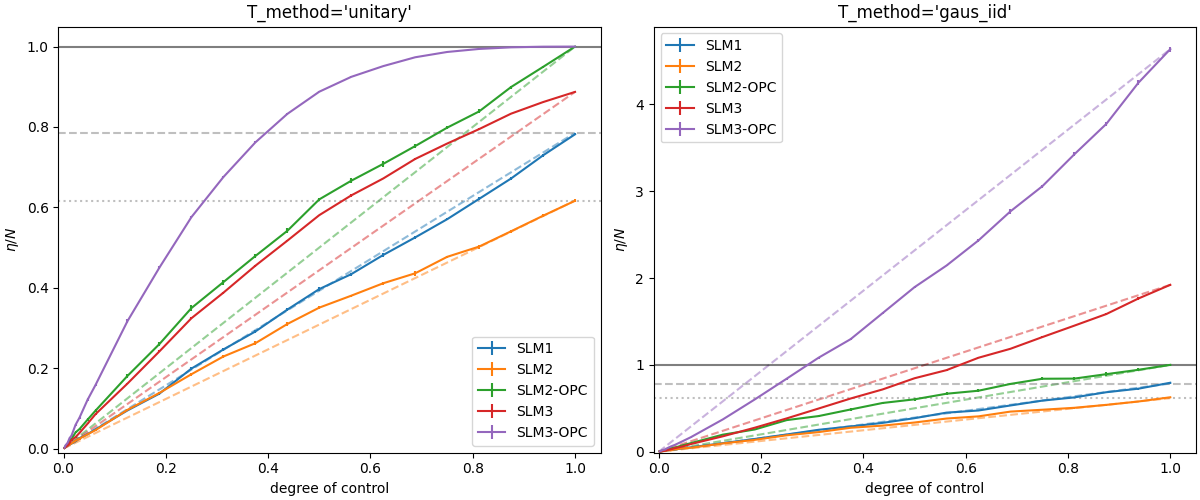

In [78]:
incomplete_control(small_control=False)

## 8.1 little control limit 

T_method='unitary': a3=1.322+-0.001; b3=0.000 +- 0.000
T_method='unitary': a3opc=2.510+-0.005; b3opc=0.000 +- 0.000
T_method='gaus_iid': a3=1.331+-0.004; b3=0.000 +- 0.000
T_method='gaus_iid': a3opc=2.601+-0.004; b3opc=0.000 +- 0.000


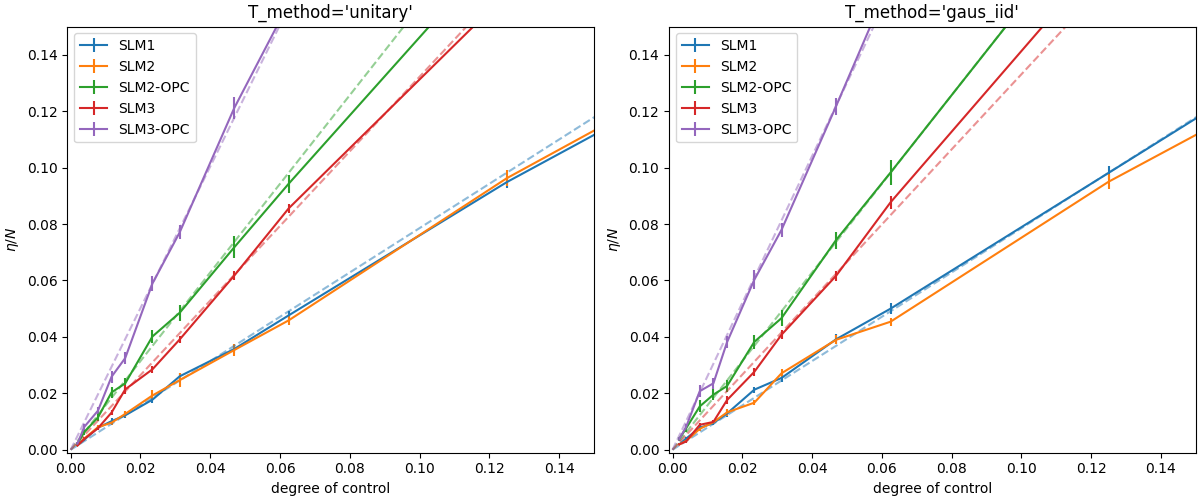

In [86]:
# TODO: this does not quite work well yet, the slopes come out a bit wierd. Also look at new data with better sampling 
incomplete_control(small_control=True)